# HW2 for CS 135 in Fall 2025

Instructions:
<https://www.cs.tufts.edu/cs/135/2025s/hw2.html>

Instructions on webpage should be considered *authoritative*. Any instructions here in this notebook are provided to be extra helpful, but when in doubt follow the webpage instructions.

This notebook is specifically for the report related to Problem 1.

# Problem 1: Binary Classifier for Cancer-Risk Screening 

### Prereq

* You will need to finish **Code Task** for **Problem 1** before working on this notebook. 

### Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics

In [ ]:
# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Autoload changes in other files.
# Avoids restarting the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2

# Import student-edited code 

Remember, you should have *completed* the Code Tasks for Problem 1 first.

In [ ]:
if not os.path.exists('binary_metrics.py'):
    raise ImportError("CANNOT FIND binary_metrics.py. Make sure you run this notebook in same directory as your .py files.")

In [ ]:
from binary_metrics import (
    calc_ACC, calc_TPR, calc_TNR)

# Import helper code (will work as provided, no edits needed)

In [ ]:
import threshold_selection

In [ ]:
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

# Provided function for computing mean binary cross entropy

Here, we provide a *completed* function you can use as is for Problem 1 report.

Later in Problem 2, you'll write your own version of this function without using sklearn.

Remember, we want the *base-2* cross entropy. For *one* pair of true label $y$ and predicted proba $p$, we have

$$
BCE(y, p) = - y \log_2 p - (1-y) \log_2(1-p)
$$

The function below computes the mean of this BCE across a whole dataset of size N

In [ ]:
def calc_mean_BCE_from_probas(ytrue_N, yproba1_N):
    ''' Compute mean binary cross entropy
    
    Args
    ----
    ytrue_N : 1D array, size (n_examples,) = (N,)
    yproba1_N : 1D array, size (n_examples,) = (N,)
    
    Returns
    -------
    mean_bce : float
        mean binary cross entropy across all N examples
    '''
    return sklearn.metrics.log_loss(ytrue_N, yproba1_N, labels=[0,1]) / np.log(2.0)

In [ ]:
# Check that BCE loss is high if true class is 1 but probability is low
calc_mean_BCE_from_probas([1.], [0.01])

6.643856189774724

In [ ]:
# Check that BCE loss is exactly 1 if true class is 1 but probability is 0.5
calc_mean_BCE_from_probas([1.], [0.5])

1.0

In [ ]:
# Check that BCE loss is close to zero if true class is 1 but probability is 0.99
calc_mean_BCE_from_probas([1.], [0.99])

0.01449956969511509

# Load x and y array data for problem 1

In [ ]:
def load_x(csv_path, feat_names=['age_0to1', 'famhistory', 'marker_0to1']):
    df = pd.read_csv(csv_path, usecols=feat_names)
    return np.asarray(df.values, dtype=np.float64)

In [ ]:
def load_y(csv_path, col_name='cancer'):
    df = pd.read_csv(csv_path, usecols=[col_name])
    return np.asarray(df.values, dtype=np.float64)

In [ ]:
# Make sure you have downloaded data and your directory is correct
DATA_DIR = os.path.join('data_cancer') 

In [ ]:
# Load 3 feature version of x arrays
x_tr_M3 = load_x(os.path.join(DATA_DIR, 'x_train.csv'))
x_va_N3 = load_x(os.path.join(DATA_DIR, 'x_valid.csv'))
x_te_N3 = load_x(os.path.join(DATA_DIR, 'x_test.csv'))

for label, x in [('train', x_tr_M3), ('valid', x_va_N3), ('test', x_te_N3)]:
    print("Loaded x_%-5s : shape %s" % (label, x.shape))

Loaded x_train : shape (390, 3)
Loaded x_valid : shape (180, 3)
Loaded x_test  : shape (180, 3)


In [ ]:
# Load 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [ ]:
N_shape = x_va_N3.shape
M_shape = x_tr_M3.shape

N = N_shape[0]
M = M_shape[0]

**TODO** : Load outcomes **y** arrays

In [ ]:
# Load outcomes y arrays
# Hint: Use the load_y helper, as we did for load_x above
y_tr_M = np.hstack([np.zeros(M//2), np.ones(M//2)]) # TODO fixme
y_va_N = np.hstack([np.zeros(N//2), np.ones(N//2)]) # TODO fixme
y_te_N = np.hstack([np.zeros(N//2), np.ones(N//2)]) # TODO fixme

## Step 1A: Data Summarization

### Table 1 for Report

Provide a table summarizing some basic properties of the provided training set, validation set, and test set:

* Row 1 'total count': how many total examples are in each set?
* Row 2 'positive label count': how many examples have a positive label (means cancer)?
* Row 3 'fraction positive' : what fraction (between 0 and 1) of the examples have cancer?

Your result should be 3 by 3 containing 'total count', 'positive label count' and 'fraction positive' of training, valid and test sets. An example of the output looks like this:

|                               | train  |valid    |test|
|:-|-:|-:|-:|
|num. total examples            |560.000  |120.000  |120.000
|num. positive examples         |56.000   |12.000   |12.000
|fraction of positive examples  |0.100    |0.100    |0.100

All results should **keep 3 digits**. We set a pandas display option to ensure that below.

**TODO**: make a pandas dataframe with the correct data properties

In [ ]:
table1_df = pd.DataFrame(dict(train=[111,222,333], valid=[444,555,666], test=[777,888,999])) # TODO fixme
table1_df.index = ['num. total examples', 'num. positive examples', 'fraction of positive examples']

**TODO:** Use pandas' built in printing to make a nice table (using a fixed-width font)

In [ ]:
pd.set_option('display.precision', 3) # Keep this, so 3 digits after decimal are printed
print(table1_df)

                               train  valid  test
num. total examples              111    444   777
num. positive examples           222    555   888
fraction of positive examples    333    666   999


##  Step 1B: The predict-0-always baseline

**TODO**: predict zero for all test data points

In [ ]:
baseline_yhat_te_N = np.random.RandomState(0).randint(low=0, high=2, size=N) # TODO fixme
print(baseline_yhat_te_N)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1
 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1
 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0]


In [ ]:
print(y_te_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, baseline_yhat_te_N, 0.5))

Predicted   0   1
True             
0          39  51
1          46  44


**TODO** Use the printed information from the previous code cell to calculate the accuracy of baseline. 

Keep 3 digits in your PDF report for short Answer 1a.

In [ ]:
baseline_acc = -1.0 # TODO: calculate the accuracy of baseline.
print("Baseline has accuracy: ", baseline_acc)

Baseline has accuracy:  -1.0


### Short Answer 1a in Report

*See instructions on website*

## Step 1C : Logistic Regression with F=2 dataset

**TODO**: Complete each line marked TODO fixme in the codeblock below

In [ ]:
C_grid = np.logspace(-4, 4, 17)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

modelF2_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list = list()
va_bce_list = list()
te_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list = list()
va_err_list = list()
te_err_list = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 2-feature dataset
    lrF2 = sklearn.linear_model.LogisticRegression() # TODO fixme
    lrF2.fit(x_tr_M2[::5], y_tr_M[::5]) # TODO fixme
    
    modelF2_list.append(lrF2)
    
    yproba1_tr_M = lrF2.predict_proba(x_tr_M2)[:,1] # The probability of class 1 on the training set
    yproba1_va_N = lrF2.predict_proba(x_va_N2)[:,1] # The probability of class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list.append(my_tr_err)
    va_err_list.append(my_va_err)
    
    # TODO: use calc_mean_BCE_from_probas function defined above.
    my_tr_bce = my_tr_err + 0.1 # TODO fixme, calc BCE on train set
    my_va_bce = my_va_err + 0.15 # TODO fixme, calc BCE on valid set
    # Save bce for future selection
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 

Make plot to visualize mean BCE and ERR over C values (internal debugging only)

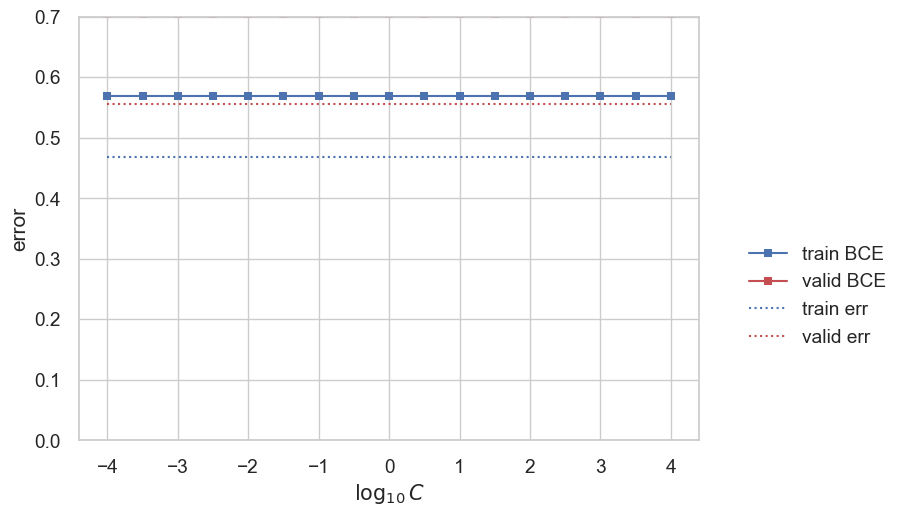

In [ ]:
plt.plot(np.log10(C_grid), tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.33, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

In [ ]:
print("Searched over these C values:")
print(C_grid)

print("Recorded these BCE loss values on val set")
print(va_bce_list)

Searched over these C values:
[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
Recorded these BCE loss values on val set
[0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556, 0.7055555555555556]


**TODO** Find the best C with the samllest cross entropy loss on the validation set.

In [ ]:
# Find the C that corresponds to the smallest BCE loss on the validation set
best_C__lrF2 = C_grid[0] # TODO fixme

print("Best C value for F2 model:")
print(best_C__lrF2)

Best C value for F2 model:
0.0001


**TODO** Load the model that was rated 'best'

In [ ]:
best_lrF2 = modelF2_list[0] # TODO fixme

print("Best model has coefficient values:")
print(best_lrF2.coef_)

Best model has coefficient values:
[[ 0.53565638 -0.16580162]]


In [ ]:
# Output the prediction of your best model for 2-feature data on the training, valid, and test set. 
# Return the probability of predicting positive class
# We'll use them for the ROC curve later.

bestlrF2_yproba1_tr_M = best_lrF2.predict_proba(x_tr_M2)[:,1]
bestlrF2_yproba1_va_N = best_lrF2.predict_proba(x_va_N2)[:,1]
bestlrF2_yproba1_te_N = best_lrF2.predict_proba(x_te_N2)[:,1]

# Remember: predict_proba returns a 2D array with TWO columns
# we use [:, 1] to grab the second column, corresponding to the positive class
# the first column is the probability of the negative class (no cancer)

## Step 1D : Logistic Regression with F=3 dataset
**TODO**: 
* Repeat Step 1C for 3-feature dataset to find the best C. Use same C_grid and same way to pick best on val set.
* Copy that block of code from above here, and modify accordingly...

In [ ]:
# TODO codeblock that fits model for each C and measures error

In [ ]:
# TODO codeblock that visualizes error as function of C (for your own debugging purposes)

In [ ]:
# TODO codeblock that finds the best C value and corresponding best LR model

**TODO**:
* Using your best F=3 model, predict the probability of predicting positive class (y=1) on training, validation and test set.

In [ ]:
# TODO: Return the posibility of predicting true on training, validation and test set.
# Hint: follow what's done in the last code block of Step 1C.

prng = np.random.RandomState(101)
bestlrF3_yproba1_tr_M = prng.rand(M) # TODO fixme, we're just filling with random values for now
bestlrF3_yproba1_va_N = prng.rand(N) # TODO fixme
bestlrF3_yproba1_te_N = prng.rand(N) # TODO fixme

## Step 1E : Comparing Models using ROC Analysis


**TODO**:

1) Review the sklearn documentation for using [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

2) Skim the sklearn User Guide on [ROC curves](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)

3) Follow instructions below to produce a ROC figure for your report

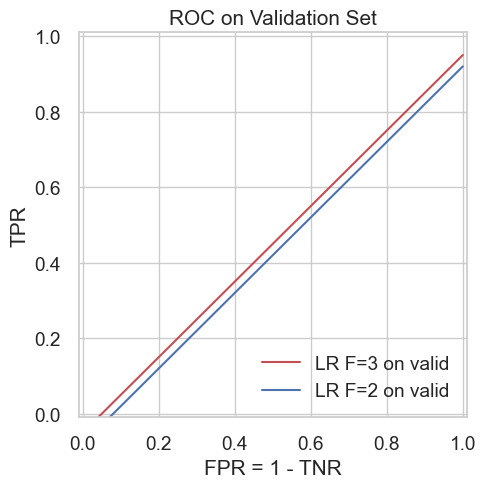

In [ ]:
# ROC curve comparing F=2 and F=3 logistic regression (LR) models

# Create square aspect-ratio figure
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# TODO Use provided true labels and predictions for validation set
# Call `sklearn.metrics.roc_curve'. See links above to User Guide and docs.
# This will produce arrays of fpr (false pos rate) and tpr (true pos rate) values,
# That you can use to make the ROC plot, replacing the dummy fpr/tpr values below.

# Read HW2 instructions carefully to verify correct plot style (line type, line color, etc.)

fpr, tpr = np.linspace(1., 0., 51), 1-np.linspace(0., 1., 51) - 0.05; # TODO fixme
plt.plot(fpr, tpr, 'r-', label='LR F=3 on valid');

fpr, tpr = np.linspace(1., 0., 51), 1-np.linspace(0., 1., 51) - 0.08; # TODO fixme
plt.plot(fpr, tpr, 'b-', label='LR F=2 on valid');

plt.title("ROC on Validation Set");
plt.xlabel('FPR = 1 - TNR');
plt.ylabel('TPR');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

### Figure 1 for Report: Comparing models using ROC analysis

**TODO**: *Include the above figure in your report*.

### Short Answer 1b for Report

*See instructions on website*

## Selecting a decision threshold

Remember that to turn predicted probabilities into binary decisions, we need a threshold.

Steps 1F and 1G describe two ways to pick such a threshold.

**Best Practice throughout**: Pick threshold on validation set. Measure ultimate performance on test set.

## Step 1F: Use F=3 LR with threshold = 0.5

In [ ]:
default_thr = 0.5

# TODO calculate Confusion Matrix for this threshold
# ___ = calc_confusion_matrix_for_probas_and_threshold(___)
# See previous usage in Step 1B above
cmat_df = None

# TODO compute True Positive Rate (TPR)
tpr = 0.0 # TODO fixme

# TODO compute True Negative Rate (TNR)
tnr = 0.0 # TODO fixme

print(f"Fig. 2 column 1:\n\nthreshold = {default_thr :.3f}\n")
print(cmat_df)
print(f"\nTPR = {tpr :.3f}\nTNR = {tnr :.3f}")

Fig. 2 column 1:

threshold = 0.500

None

TPR = 0.000
TNR = 0.000


## Step 1G : Use F=3 LR with threshold to maximize TNR s.t. TPR >= 0.95

In [ ]:
# Compute performance metrics across possible thresholds from 0.0 to 1.0
# Here, we're looking at VALIDATION set

thresh_grid, va_perf_grid = threshold_selection.compute_perf_metrics_across_thresholds(
    y_va_N, bestlrF3_yproba1_va_N)

In [ ]:
# Inspect what the above returned...

# thresh_grid is a big 1D array of possible thresholds
# va_perf_grid is a dict, where each key gives a 1D array same size as thresh_grid

# See only the first 3 entries
for gg in range(3):
    print('thr', thresh_grid[gg])
    print('ACC', va_perf_grid['acc'][gg])
    print('TPR', va_perf_grid['tpr'][gg])
    print('TNR', va_perf_grid['tnr'][gg])
    print()
print("...")

thr 0.0
ACC nan
TPR nan
TNR nan

thr 0.0004419948498006754
ACC nan
TPR nan
TNR nan

thr 0.001044057550240951
ACC nan
TPR nan
TNR nan

...


**TODO**: Write code to find the threshold that maximizes TNR while TPR >= 0.95

In [ ]:
# Find threshold that makes TNR as large as possible, while satisfying TPR >= 0.95

# Make arrays for threshold, TPR, and TNR
# Make smaller arrays such that all entries satisfy the TPR constraint
# Search for the largest TNR value, and keep corresponding threshold

best_thr = 0.5 # TODO fixme

In [ ]:
# TODO calculate Confusion Matrix for this threshold
# ___ = calc_confusion_matrix_for_probas_and_threshold(___)
# See previous usage in Step 1B above
cmat_df = None

# TODO compute True Positive Rate (TPR)
tpr = -1.0 # TODO fixme

# TODO compute True Negative Rate (TNR)
tnr = -1.0 # TODO fixme

print(f"Fig. 2 column 2:\n\nthreshold = {default_thr :.3f}\n")
print(cmat_df)
print(f"\nTPR = {tpr :.3f}\nTNR = {tnr :.3f}")

Fig. 2 column 2:

threshold = 0.500

None

TPR = -1.000
TNR = -1.000


### Table 2 for Report

See instructions on website on how to combine material from Step 1F and Step 1G
to produce a table.


Each column should correspond to one of the following models:

* F=3 Logistic Regression using threshold 0.5 from 1F
* F=3 Logistic Regression using selected threshold from 1G

Each row should report the performance of the model on the test set

* Top: Threshold
* Middle: confusion matrix on the test set
* Bottom: TPR and TNR on the test set




### Short Answer 1c and 1d for Report

*See instructions on website*